In [23]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Read Image
Open the image as luminance map. This uses the formula
$$((r * g * b) / 3)$$

In [24]:
# Open image as luminance map
img = Image.open(
    '/home/lucie/Downloads/sphere.jpeg').convert('L')  # ((r*g*b)/3)
img_np = np.array(img)

PMI Calculation
---
### "Crisp Boundary Detection Using Pointwise Mutual Information"
Phillip Isola, Daniel Zoran, Dilip Krishnan, and Edward H. Adelson, 2014, [URL](http://web.mit.edu/phillipi/www/publications/crisp_boundaries.pdf)

Now calculate the PMI (pointwise mutual information) for each pixel x and it's lower or right neighbor y:
$$\mbox{PMI}(x,y) = \log_2\bigg(\frac{P(x,y)}{P(x) P(y)}\bigg)$$
PMI tells us whether the occurrence of two neighboring pixel values is more than random (i.e. a pattern). If it occurs less often, we can interpret it as border between patterns.

This code does not implement the approach of the paper, but a rather simplified version of it.

In [25]:
output = []

for type in ["lower", "right"]:
    if type == "lower":
        # Get pixel pairs (pixel and its lower neighbor)
        A = img_np[:-1, :].ravel()
        B = img_np[1:, :].ravel()
        
        m = [1, 0]  # used later for indexing
        
    elif type == "right":
        # Get pixel pairs (pixel and its right neighbor)
        A = img_np[:, :-1].ravel()
        B = img_np[:, 1:].ravel()
        
        m = [0, 1]
    
    # Compute joint and marginal probabilities
    bins = 256
    joint_hist, _, _ = np.histogram2d(A, B, bins=bins, range=[[0,255],[0,255]])
    joint_prob = joint_hist / joint_hist.sum()
    pA = joint_prob.sum(axis=1, keepdims=True)  # marginal probs
    pB = joint_prob.sum(axis=0, keepdims=True)
    
    # Compute PMI matrix
    with np.errstate(divide='ignore', invalid='ignore'):
        pmi_matrix = np.log(joint_prob / (pA @ pB))
        pmi_matrix[np.isinf(pmi_matrix)] = 0
        pmi_matrix = np.nan_to_num(pmi_matrix)
    
    # Map PMI values back to image shape
    # For each pixel, assign probability of co-occurrence between it and its neighbor's value
    pmi_image = np.zeros_like(img_np, dtype=float)
        
    for i in range(img_np.shape[0] - m[0]):
        for j in range(img_np.shape[1] - m[1]):
            a = img_np[i, j]
            b = img_np[i + m[0], j + m[1]]
            pmi_image[i, j] = pmi_matrix[a, b]
    
    # Normalize
    output.append((pmi_image - np.min(pmi_image)) / (np.max(pmi_image) - np.min(pmi_image)))

# Plotting
Plot the results for both lower and right neighbors

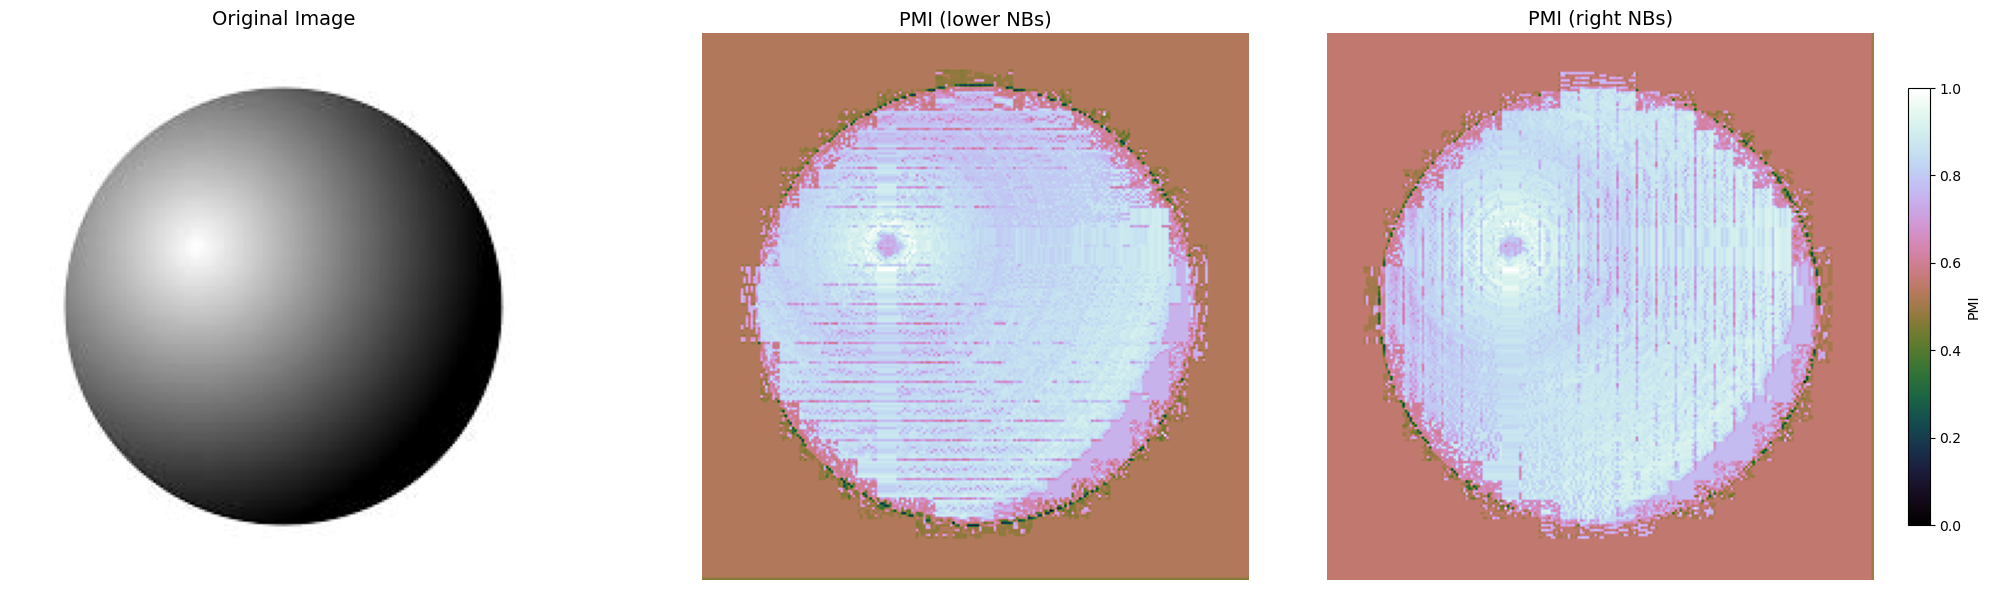

In [26]:
# Plot both original and PMI images side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 6))

# Original image
ax1.imshow(img_np, cmap='gray')
ax1.set_title('Original Image', fontsize=14)
ax1.axis('off')

# PMI filtered image using lower neighbors
im2 = ax2.imshow(output[0], cmap='cubehelix')
ax2.set_title('PMI (lower NBs)', fontsize=14)
ax2.axis('off')

# PMI filtered image using right neighbors
im3 = ax3.imshow(output[1], cmap='cubehelix')
ax3.set_title('PMI (right NBs)', fontsize=14)
ax3.axis('off')

# Add colorbar for PMI image
plt.colorbar(im3, ax=ax3, label='PMI', shrink=0.8)

plt.tight_layout()
plt.show()

The higher values (here pink) describe a more likely co-occurrence of pixel neighbors whereas the lower values (here black) describe a less likely co-occurrence. The border areas of the coin seem to occur less likely, also inbetween material changes are highlighted.